In [1]:
import pandas as pd

import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
df =  pd.read_csv('training.csv')

In [3]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
df['label'].value_counts

<bound method IndexOpsMixin.value_counts of 0        sadness 
1        sadness 
2           anger
3            love
4           anger
           ...   
15995    sadness 
15996    sadness 
15997         joy
15998       anger
15999    sadness 
Name: label, Length: 16000, dtype: object>

In [5]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
# Checking total categories
df['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

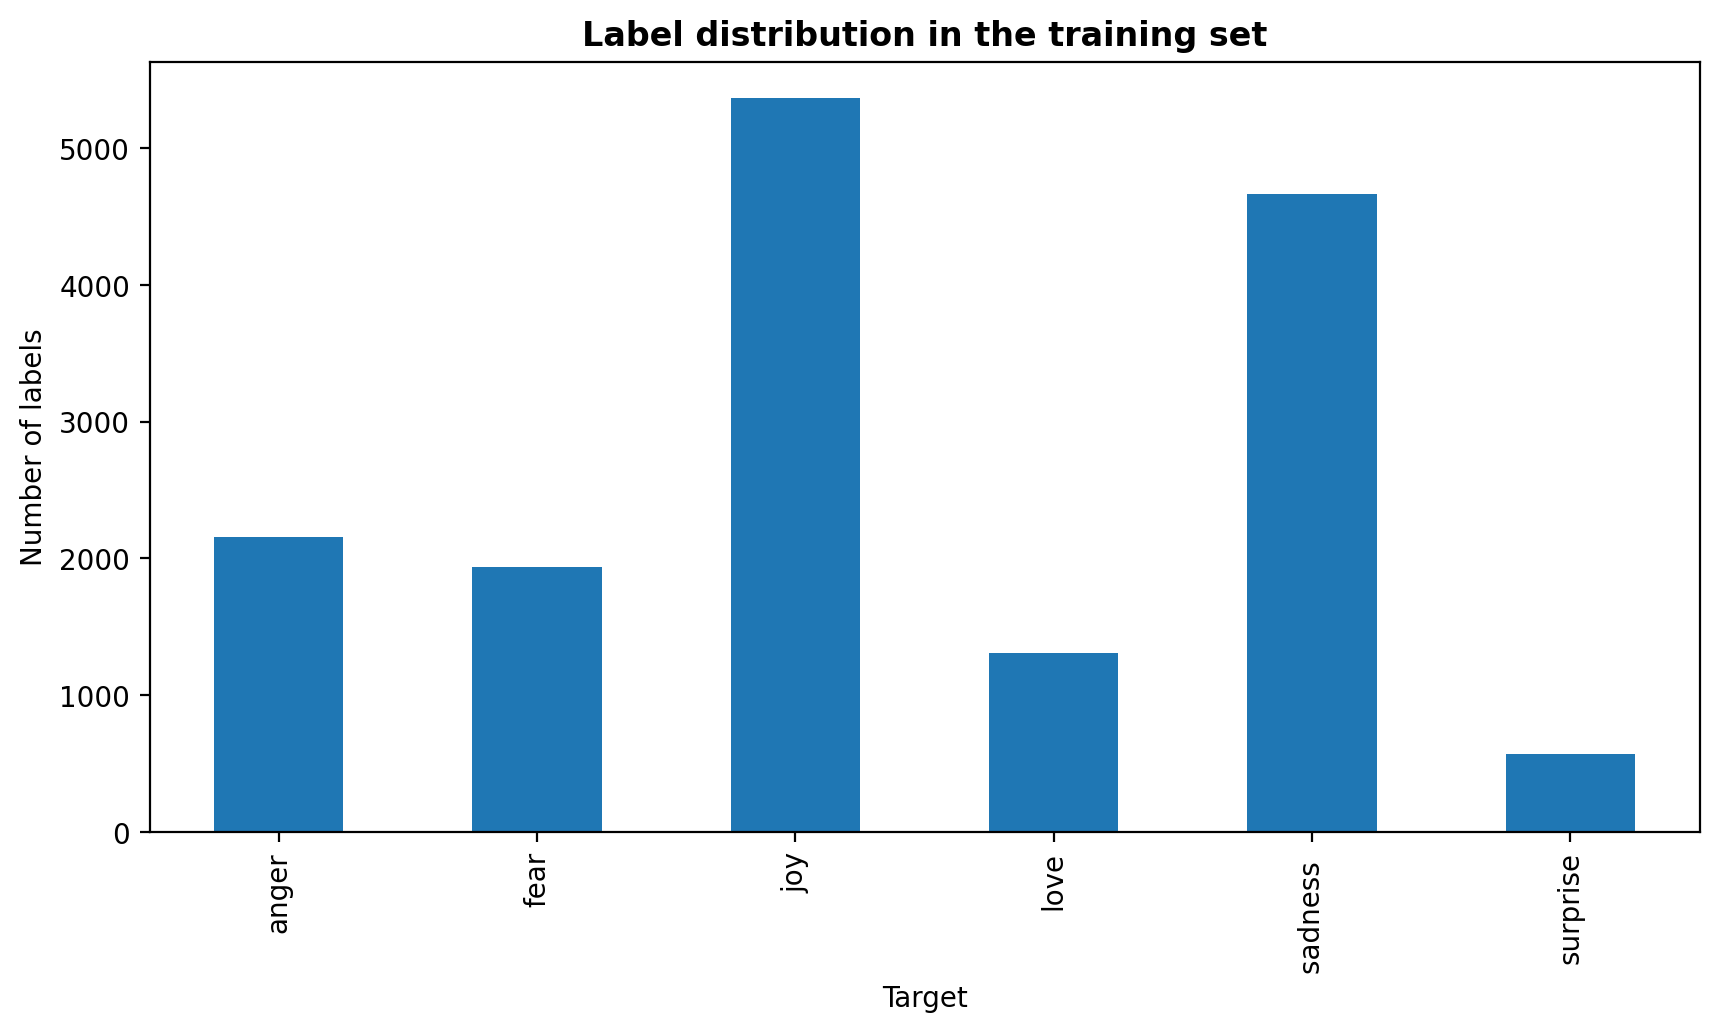

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
# Check target balance
df['label'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Label distribution in the training set', fontweight="bold")
plt.xlabel('Target')
plt.ylabel('Number of labels')
plt.show()

In [8]:
# Changing text to number representation for 'labels'
df['Object'] = df['label'].astype("category").cat.codes
# Checking the new column
df.sample(10)

In [10]:
total_categories = len(df['Object'].unique())
total_categories

6

In [11]:
# Assuming df is your DataFrame
unique_objects = df['Object'].unique()
total_categories = len(unique_objects)

# Print each unique object
for obj in unique_objects:
    print(obj)

# Print the total number of unique objects
print("Total categories:", total_categories)


4
0
3
5
1
2
Total categories: 6


In [12]:
# Create a dictionary to map labels to their code values
label_code_mapping = dict(zip(df['label'], df['Object']))

# Print label and its code value
for label, code in label_code_mapping.items():
    print("Label:", label, "| Code:", code)


Label: sadness  | Code: 4
Label: anger | Code: 0
Label: love | Code: 3
Label: surprise | Code: 5
Label: fear | Code: 1
Label: joy | Code: 2


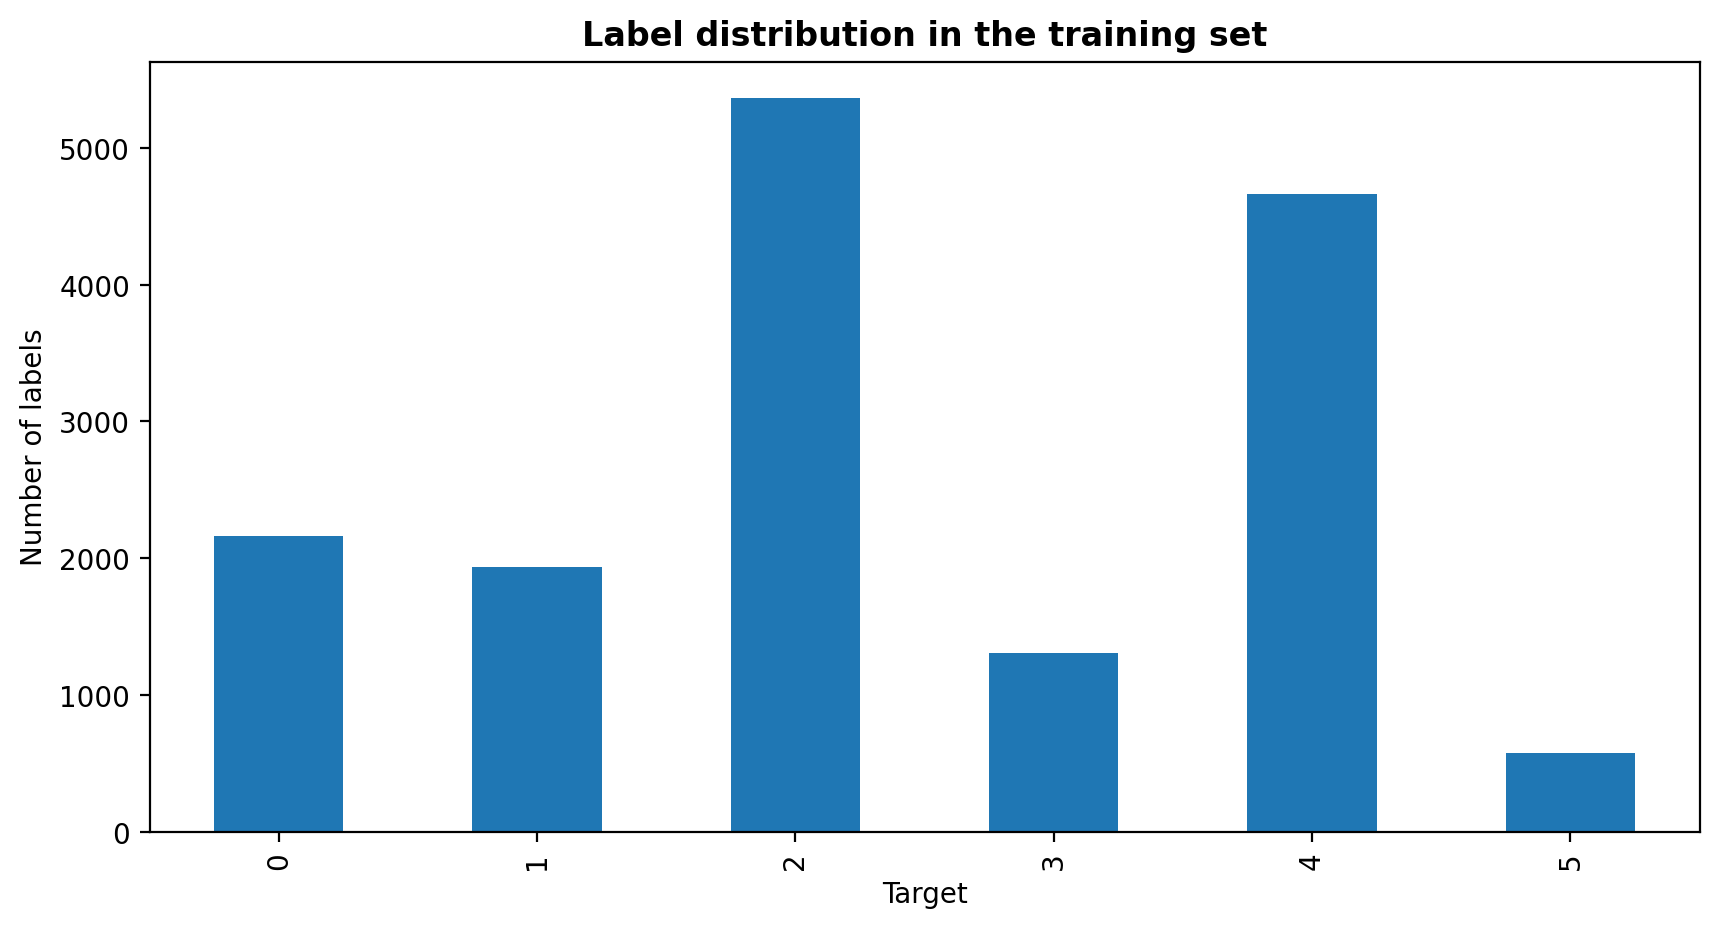

In [13]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
# Check target balance
df['Object'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Label distribution in the training set', fontweight="bold")
plt.xlabel('Target')
plt.ylabel('Number of labels')
plt.show()

# RNN **↓**

In [14]:
from sklearn.model_selection import train_test_split

random_seed = 42  # Your preferred random seed value

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)


In [15]:
# Convert sentences into sequences of numbers
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE) # only tikenize the top 3000 words most frequents
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [16]:
# Total words found in the dictionary
word2idx = tokenizer.word_index
#V = total_words
total_words = len(word2idx)
print(f'total unique words {total_words}')

total unique words 13527


In [17]:
# pad sequences
data_train = pad_sequences(sequences_train)
print(f'Shape of data train tensor: {data_train.shape}')

# get sequence length
length = data_train.shape[1]

Shape of data train tensor: (12800, 61)


In [18]:

data_test = pad_sequences(sequences_test, maxlen=length)
print('Shape of data test tensor:', data_test.shape)
 

Shape of data test tensor: (3200, 61)


In [19]:
# Creating the model

# We get to choose embedding dimensionality
D = 50

i = Input(shape=(length ,))
x = Embedding(total_words+1,D)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(total_categories)(x)

model = Model(i,x)

In [20]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')

r = model.fit(
  data_train,
  df_train['Object'],
  epochs=30,
  validation_data=(data_test, df_test['Object'])
)


Training model...
Epoch 1/30


400/400 [==============================] - 14s 22ms/step - loss: 1.3707 - accuracy: 0.4901 - val_loss: 0.8645 - val_accuracy: 0.7878
Epoch 2/30
400/400 [==============================] - 9s 23ms/step - loss: 0.5522 - accuracy: 0.8452 - val_loss: 0.4529 - val_accuracy: 0.8456
Epoch 3/30
400/400 [==============================] - 10s 26ms/step - loss: 0.3466 - accuracy: 0.8922 - val_loss: 0.3408 - val_accuracy: 0.8894
Epoch 4/30
400/400 [==============================] - 9s 22ms/step - loss: 0.2680 - accuracy: 0.9119 - val_loss: 0.2920 - val_accuracy: 0.8956
Epoch 5/30
400/400 [==============================] - 10s 26ms/step - loss: 0.2089 - accuracy: 0.9252 - val_loss: 0.2548 - val_accuracy: 0.9034
Epoch 6/30
400/400 [==============================] - 14s 35ms/step - loss: 0.1685 - accuracy: 0.9405 - val_loss: 0.2489 - val_accuracy: 0.9041
Epoch 7/30
400/400 [==============================] - 11s 28ms/step - loss: 0.1426 - accuracy: 0.9471 - val_loss: 0.2

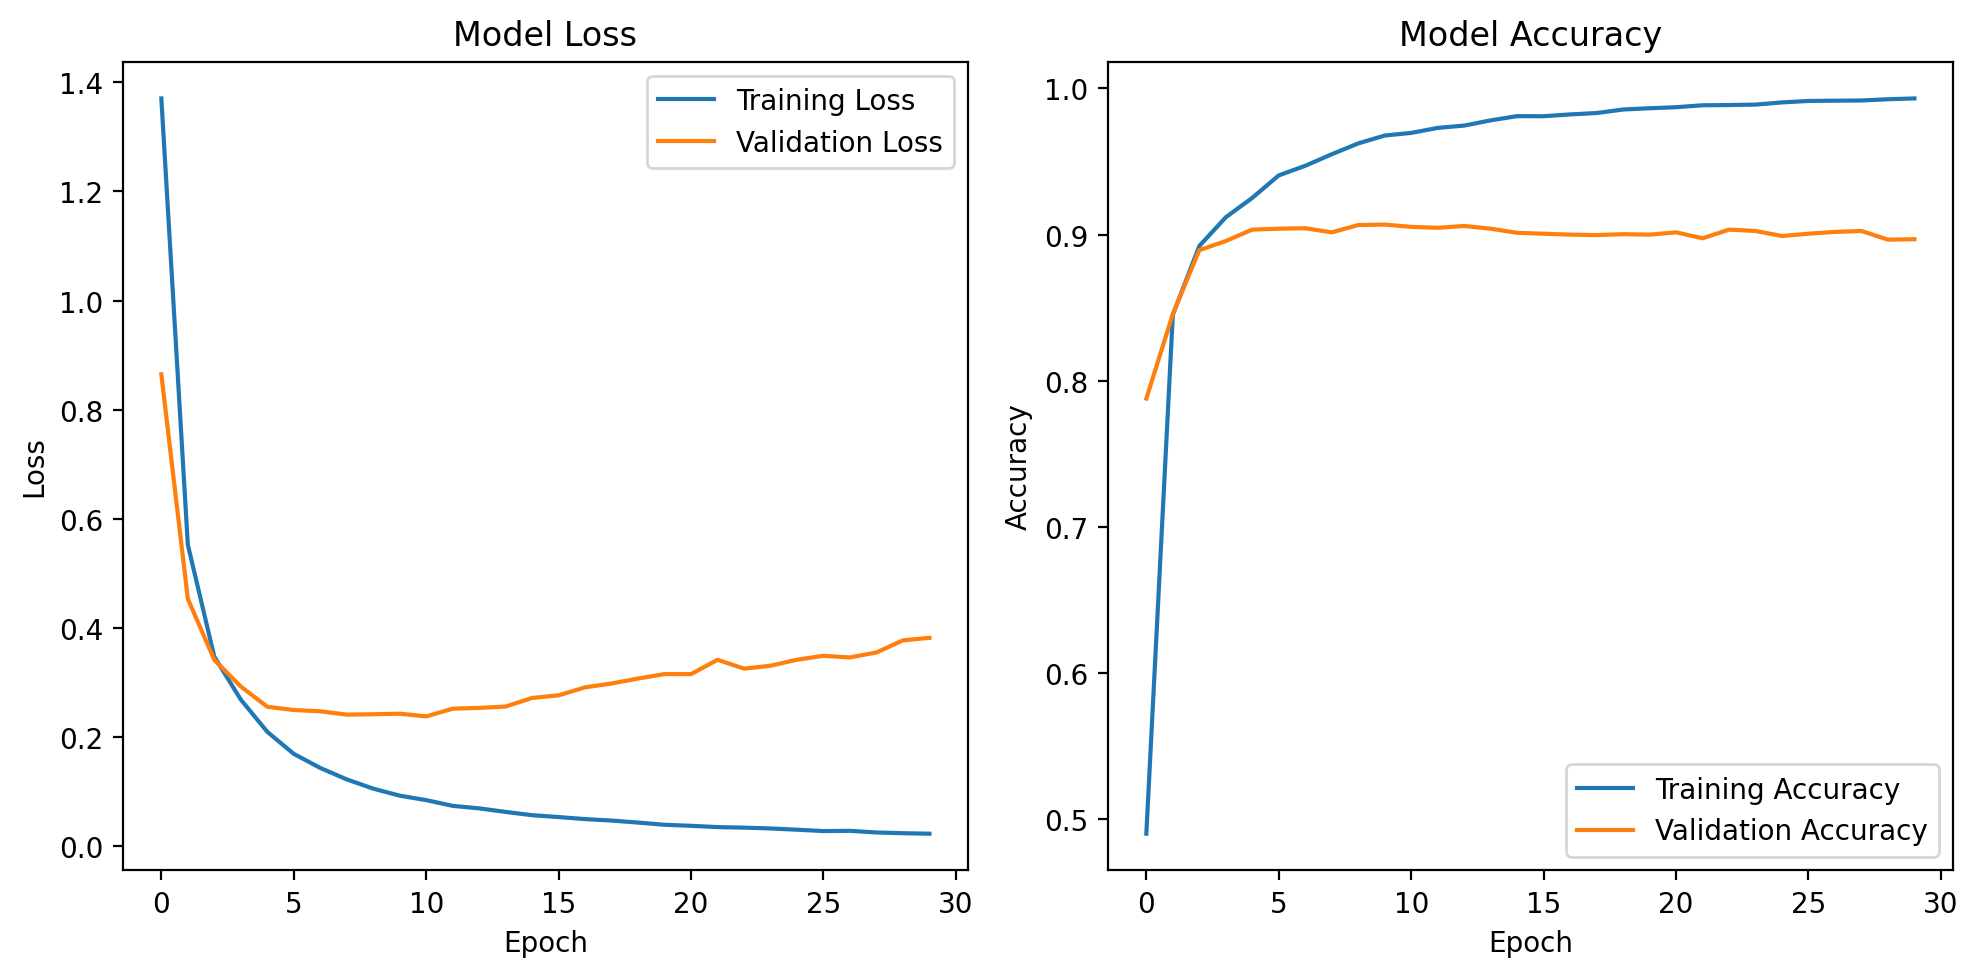

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import classification_report


predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)


y_true = df_test['Object']


report = classification_report(y_true, y_pred)
print(report)

100/100 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       427
           1       0.83      0.89      0.86       397
           2       0.91      0.93      0.92      1021
           3       0.83      0.76      0.80       296
           4       0.93      0.94      0.94       946
           5       0.83      0.74      0.79       113

    accuracy                           0.90      3200
   macro avg       0.88      0.85      0.86      3200
weighted avg       0.90      0.90      0.90      3200



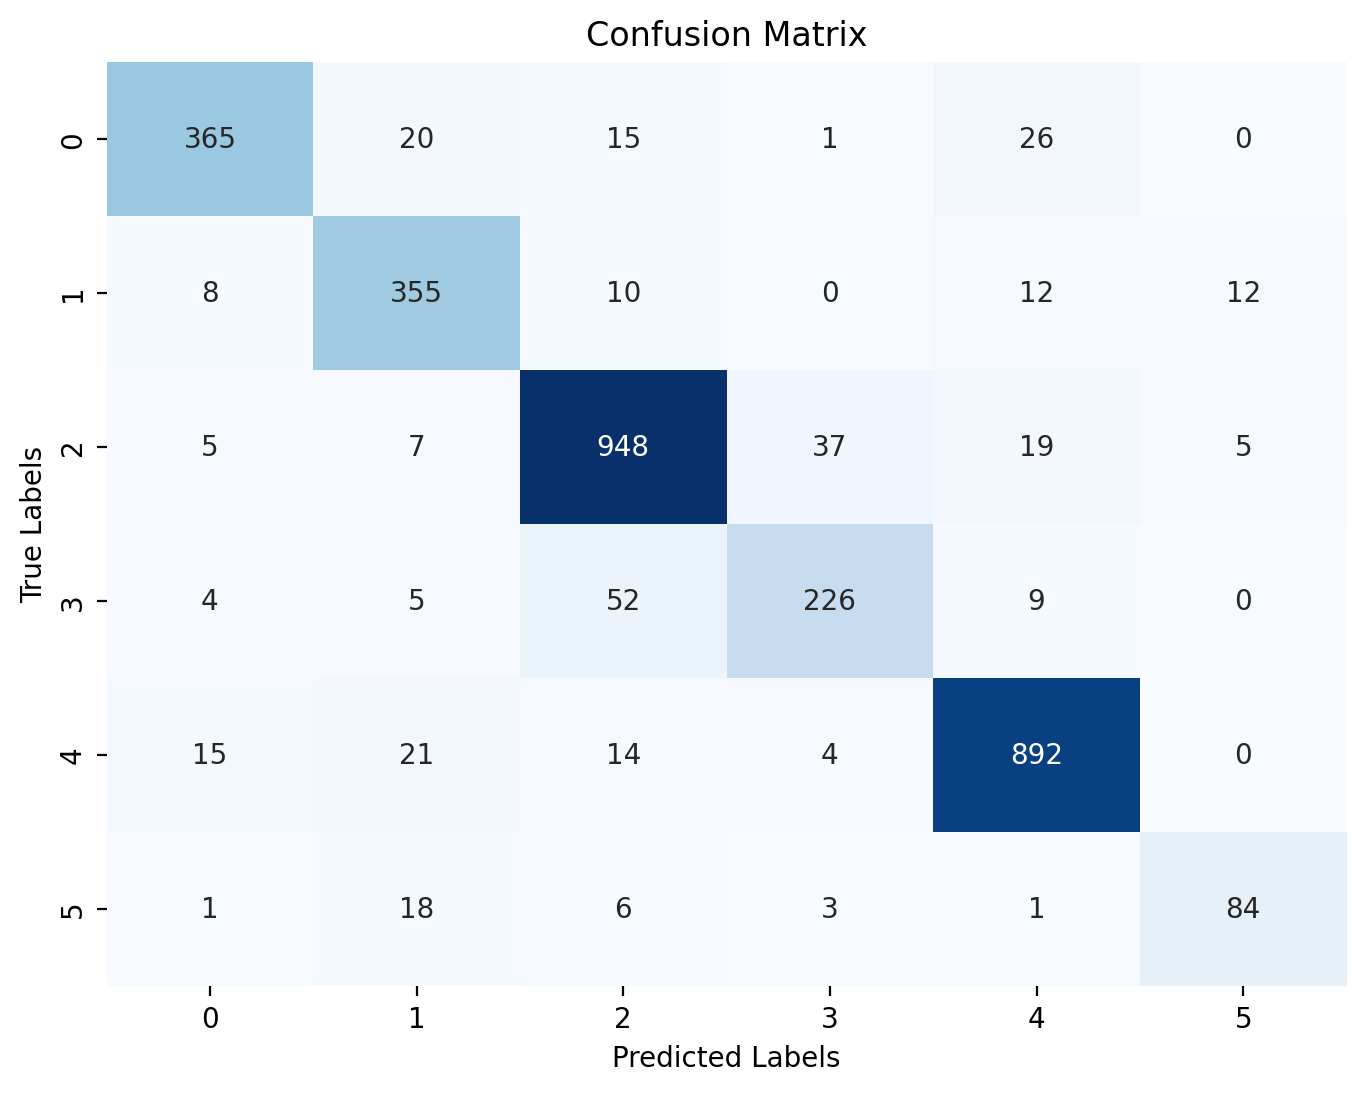

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [24]:
model.save("RNN_Final_Model.h5")

c:\Users\Sajjad Alvi\AppData\Local\anaconda3\envs\vrtry\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
